In [537]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#LOF
from sklearn.neighbors import LocalOutlierFactor

from collections import Counter
from collections import defaultdict

### Schema

For detecting outliers we will not rely on just one estimator, but we will use a combination of them.<br>
In order to reduce the dimensionality of our data, we will use a PCA projection. <br>
After evaluating each anomaly estimator on our data, we will add a column to the original dataset indicating whether that row is an outlier or not.<br>
After all estimator have been tested on our data, we will take a majority voting.<br> For each row of data we will consider it an outlier if the majority of the estimator agreed on that estimate.

In [538]:
df = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Datasets/echo_features.csv')
df.set_index('track_id', inplace=True)
df.drop('listens',axis=1, inplace=True)
df.drop('comments', axis=1, inplace=True)
df = df[df['genre_top'].isin(['Rock','Jazz'])]
df.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,duration,bit_rate
track_id,,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,128.537,0.788251,Jazz,82,256
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,120.790,0.650452,Jazz,326,256
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,135.468,0.682397,Jazz,354,256
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,120.218,0.917613,Jazz,232,256
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock,405,256


In [539]:
# Data preprocessing
le = preprocessing.LabelEncoder()
df['genre_top'] = le.fit_transform(df['genre_top'])
print('Legend:\n0: Jazz\n1: Rock')
# Define the labels
labels = df[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels[['genre_top']]

Legend:
0: Jazz
1: Rock


In [540]:
df.columns

Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'genre_top', 'duration',
       'bit_rate'],
      dtype='object')

In [541]:
columnsTitles = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'valence', 'tempo', 'duration',
       'bit_rate', 'genre_top']
df = df.reindex(columns=columnsTitles)

In [542]:
df.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,genre_top
track_id,,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,0.788251,128.537,82,256,0
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,0.650452,120.790,326,256,0
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,0.682397,135.468,354,256,0
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,0.917613,120.218,232,256,0
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,0.034018,90.241,405,256,1


# Boxplot - IQR score

In [543]:
#function that detect outliers based on IQR 
def outlier_detector(var):
    ''' function that calculates Q1,Q3,IQR and return the number of outliers of a given variable'''
    Q1=df[var].quantile(0.25)
    Q3=df[var].quantile(0.75)
    IQR=Q3-Q1
    
    print('{}:'.format(var))
    print('Q1: {}\nQ3: {}\nIQR: {}'.format(Q1,Q3,IQR))
    
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    
    print('lower range: {}\nupper range: {}'.format(lower_whisker,upper_whisker))
    outliers = sum(df[var]<lower_whisker) + sum(df[var]>upper_whisker)
    print('{} has {} potential outliers'.format(var,outliers))
    


    #function that removes outliers
def outlier_remove(variable,u_whisker, l_whisker):
    df_clean.drop(index=df[df[variable]< l_whisker].index, inplace=True)
    df_clean.drop(index=df[df[variable]> u_whisker].index, inplace=True)
    

#### Acusticness - Danceability - Energy - Instrumentalness - Liveness - Speechiness - Valence

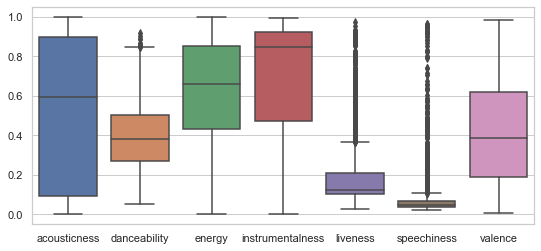

In [544]:
plt.figure(figsize=(9,4))

sns.boxplot(data=df.iloc[:,:7])
sns.set(rc={'figure.figsize':(25,8.27)})


In [545]:
for col in df.iloc[:,:7].columns:
    outlier_detector(var=col)
    print('\n')

acousticness:
Q1: 0.0943255199
Q3: 0.8984479226
IQR: 0.8041224026999999
lower range: -1.1118580841499999
upper range: 2.1046315266499995
acousticness has 0 potential outliers


danceability:
Q1: 0.2718615333
Q3: 0.5014793736
IQR: 0.22961784029999993
lower range: -0.07256522714999986
upper range: 0.8459061340499998
danceability has 11 potential outliers


energy:
Q1: 0.4328016497
Q3: 0.850100651
IQR: 0.41729900129999997
lower range: -0.19314685224999995
upper range: 1.47604915295
energy has 0 potential outliers


instrumentalness:
Q1: 0.4706153581
Q3: 0.9221123476
IQR: 0.45149698950000006
lower range: -0.2066301261500001
upper range: 1.5993578318500001
instrumentalness has 0 potential outliers


liveness:
Q1: 0.1042909085
Q3: 0.2091967113
IQR: 0.1049058028
lower range: -0.0530677957
upper range: 0.36655541550000004
liveness has 413 potential outliers


speechiness:
Q1: 0.0356185229
Q3: 0.0652800763
IQR: 0.029661553400000006
lower range: -0.008873807200000007
upper range: 0.1097724064000

#### Tempo - Bit Rate

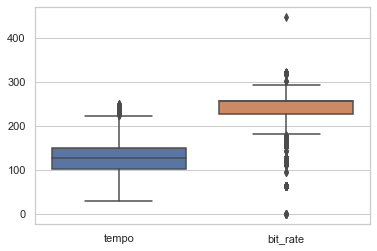

In [546]:
plt.figure(figsize=(6,4))
sns.set_style(style="whitegrid")
sns.set_color_codes()

sns.boxplot(data=df[['tempo','bit_rate']])
sns.set(rc={'figure.figsize':(15,19.27)})


In [547]:
for col in ['tempo','bit_rate']:
    outlier_detector(var=col)
    print('\n')

tempo:
Q1: 101.785
Q3: 150.287
IQR: 48.50200000000001
lower range: 29.031999999999982
upper range: 223.04000000000002
tempo has 21 potential outliers


bit_rate:
Q1: 226.0
Q3: 256.0
IQR: 30.0
lower range: 181.0
upper range: 301.0
bit_rate has 1182 potential outliers




#### duration

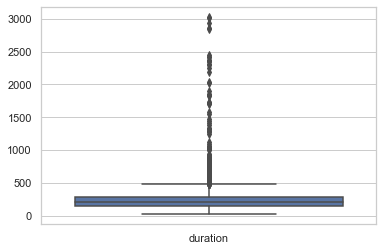

In [548]:
plt.figure(figsize=(6,4))
sns.set_style(style="whitegrid")
sns.set_color_codes()

sns.boxplot(data=df[['duration']])

In [549]:
outlier_detector(var='duration')

duration:
Q1: 147.0
Q3: 280.0
IQR: 133.0
lower range: -52.5
upper range: 479.5
duration has 226 potential outliers


# Reduce dimensionality with PCA

In [550]:
genres = df['genre_top']
df.drop('genre_top', axis=1, inplace=True)
df.dropna(inplace=True)
df.isnull().sum()

acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
valence             0
tempo               0
duration            0
bit_rate            0
dtype: int64

In [551]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

In [552]:
pca = PCA(2,random_state=42)
pca.fit(scaled_df)
df_pca = pca.transform(scaled_df)
df_pca = pd.DataFrame(df_pca, columns= ['pca1', 'pca2'])

Text(0.5, 1.0, 'Data distribution in 2D')

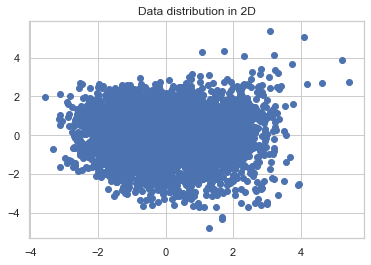

In [553]:
sns.set_style(style="whitegrid")
sns.set_color_codes()
plt.figure(figsize=(6,4))
plt.scatter(df_pca['pca1'],df_pca['pca2'])
plt.title('Data distribution in 2D')

# DBSCAN

In [554]:
from sklearn.cluster import DBSCAN

outlier_detection = DBSCAN(eps= .3, metric='euclidean', min_samples=15, n_jobs=-1)

clusters= outlier_detection.fit_predict(df_pca)

In [555]:
# add column with outliers label
df['outlier_DBSCAN'] = clusters
df['outlier_DBSCAN'] = df['outlier_DBSCAN'].apply(lambda x: 'inlier' if x==0 else 'outlier')

Text(0.5, 1.0, 'Anomaly Score - DBSCAN')

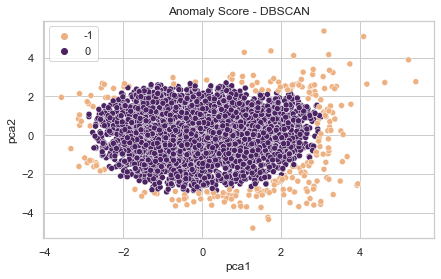

In [556]:
from matplotlib import cm
sns.set_style(style="whitegrid")
sns.set_color_codes()

plt.figure(figsize=(7,4))

cmap= cm.get_cmap('Set1')
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=clusters, palette='flare')
plt.title('Anomaly Score - DBSCAN')

In [557]:
# outlier detected
df[df['outlier_DBSCAN'] =='outlier']['outlier_DBSCAN'].value_counts()

outlier    236
Name: outlier_DBSCAN, dtype: int64

# LOF

In [558]:
from sklearn.neighbors import LocalOutlierFactor

In [559]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outliers = clf.fit_predict(df_pca) #use scaled_df for fully dimensional dataset

In [560]:
outliers

array([1, 1, 1, ..., 1, 1, 1])

In [561]:
# adding scores to df 
df['outlier_LOF'] = outliers
df['outlier_LOF'] = df['outlier_LOF'].apply(lambda x: 'inlier' if x==1 else 'outlier')

In [562]:
df[['outlier_LOF']].value_counts()

outlier_LOF
inlier         3719
outlier         414
dtype: int64

In this implementation of LOF **outliers** have a score close to **-1**, whereas **inlier** have a score close to **+1**.

In [563]:
clf.negative_outlier_factor_

array([-1.00004309, -1.03267202, -1.00168977, ..., -1.00832867,
       -0.98875878, -1.01459923])

In [564]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 414, 3719]))

### Inspecting outlier scores

In [565]:
np.where(outliers==-1)

(array([   5,    6,   21,   24,   31,   34,   36,   39,   46,   55,   70,
          74,   75,   80,   84,   89,  107,  109,  115,  117,  139,  141,
         160,  161,  179,  196,  199,  223,  224,  245,  252,  258,  290,
         292,  295,  299,  307,  311,  338,  345,  353,  362,  363,  366,
         370,  372,  374,  394,  398,  423,  465,  482,  527,  546,  548,
         583,  599,  608,  640,  643,  650,  671,  673,  686,  692,  694,
         707,  708,  710,  711,  713,  718,  724,  725,  735,  752,  774,
         787,  788,  796,  799,  810,  822,  857,  872,  876,  878,  890,
         900,  914,  915,  931,  952,  953,  957, 1006, 1021, 1082, 1086,
        1092, 1123, 1133, 1144, 1146, 1148, 1166, 1167, 1173, 1184, 1193,
        1224, 1236, 1238, 1281, 1289, 1294, 1297, 1299, 1303, 1306, 1309,
        1314, 1316, 1319, 1332, 1334, 1346, 1353, 1361, 1391, 1396, 1415,
        1446, 1511, 1514, 1519, 1523, 1557, 1562, 1564, 1569, 1577, 1579,
        1623, 1646, 1648, 1663, 1670, 

In [566]:
clf.negative_outlier_factor_[np.where(outliers==-1)]

array([-1.16624288, -1.52490456, -1.17137543, -1.09432674, -1.08688917,
       -1.09490635, -1.14170401, -1.08594535, -1.08903256, -1.09401269,
       -1.13816816, -1.10632689, -1.11498735, -1.29098176, -1.0976784 ,
       -1.2125167 , -1.08588477, -1.09565253, -1.15786278, -1.1937014 ,
       -1.11758457, -1.08932981, -1.30022321, -1.20474739, -1.22241041,
       -1.10629836, -1.12749178, -1.08525682, -1.11622578, -1.21669972,
       -1.21787151, -1.09032522, -1.16204571, -1.20017116, -1.16540906,
       -1.13442155, -1.11951334, -1.0900886 , -1.19288995, -1.12388053,
       -1.0850766 , -1.12054717, -1.15553613, -1.13037821, -1.14812617,
       -1.21424965, -1.23054086, -1.09069065, -1.10906358, -1.11439343,
       -1.27806608, -1.2819663 , -1.11374976, -1.16385972, -1.09682094,
       -1.12551479, -1.19061469, -1.09703195, -1.08703834, -1.24904627,
       -1.09581648, -1.11436199, -1.14409406, -1.18413247, -1.55831727,
       -1.20753286, -1.44275418, -1.12613671, -1.49345807, -1.13

In [567]:
# maximum outlier score
np.max(clf.negative_outlier_factor_[np.where(outliers==-1)])

-1.0833054861200906

In [568]:
# minimum outlier score
np.min(clf.negative_outlier_factor_[np.where(outliers==-1)])

-2.8373038895637004

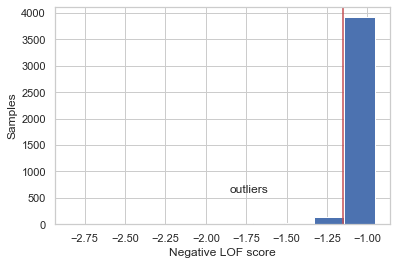

In [569]:
plt.figure(figsize=(6,4))
plt.hist(clf.negative_outlier_factor_, bins=10)
plt.axvline(-1.15, c='r')
plt.text(-1.85, 600, 'outliers')
plt.ylabel('Samples')
plt.xlabel('Negative LOF score')
plt.show()

Text(0.5, 1.0, 'Anomaly Score - LOF')

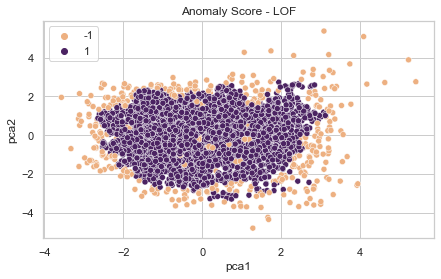

In [570]:
sns.set_style(style="whitegrid")
sns.set_color_codes()

plt.figure(figsize=(7,4))

cmap= cm.get_cmap('Set1')
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=outliers, palette='flare')
plt.title('Anomaly Score - LOF')

# KNN 

In [571]:
from pyod.models.knn import KNN

In [572]:
help(KNN)

Help on class KNN in module pyod.models.knn:

class KNN(pyod.models.base.BaseDetector)
 |  KNN(contamination=0.1, n_neighbors=5, method='largest', radius=1.0, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=1, **kwargs)
 |  
 |  kNN class for outlier detection.
 |  For an observation, its distance to its kth nearest neighbor could be
 |  viewed as the outlying score. It could be viewed as a way to measure
 |  the density. See :cite:`ramaswamy2000efficient,angiulli2002fast` for
 |  details.
 |  
 |  Three kNN detectors are supported:
 |  largest: use the distance to the kth neighbor as the outlier score
 |  mean: use the average of all k neighbors as the outlier score
 |  median: use the median of the distance to k neighbors as the outlier score
 |  
 |  Parameters
 |  ----------
 |  contamination : float in (0., 0.5), optional (default=0.1)
 |      The amount of contamination of the data set,
 |      i.e. the proportion of outliers in the data set. U

In [573]:
clf = KNN(n_neighbors=5)
clf.fit(scaled_df)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [574]:
clf.decision_scores_

array([1.06668177, 1.08032215, 1.34892278, ..., 1.65840796, 1.48729988,
       1.6459205 ])

In [575]:
anomlay_score = clf.decision_function(scaled_df)

In [576]:
outliers = clf.predict(scaled_df)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([3786,  347]))

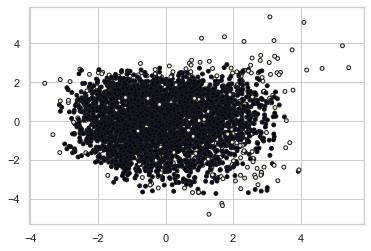

In [577]:
plt.figure(figsize=(6,4))
plt.scatter(df_pca['pca1'],df_pca['pca2'],s=15,c=outliers,edgecolors='k')

In [578]:
df['outlier_KNN'] = outliers 
df['outlier_KNN'] = df['outlier_KNN'].apply(lambda x: 'inlier' if x==0 else 'outlier')

# ABOD

In [579]:
#pip install pyod

In [580]:
from pyod.models.abod import ABOD

In [581]:
clf = ABOD(n_neighbors=20)
clf.fit(scaled_df)

ABOD(contamination=0.1, method='fast', n_neighbors=20)

In [582]:
clf.decision_scores_

array([-0.05374943, -0.04813364, -0.03587929, ..., -0.00737732,
       -0.00810373, -0.00977119])

In [583]:
outliers = clf.predict(scaled_df)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([3727,  406]))

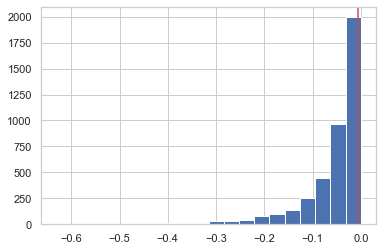

In [584]:
plt.figure(figsize=(6,4))
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='r')
plt.show()

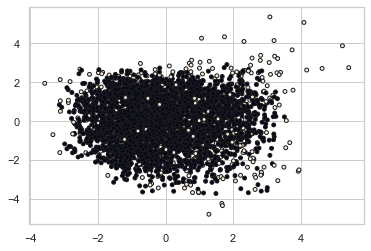

In [585]:
plt.figure(figsize=(6,4))
plt.scatter(df_pca['pca1'],df_pca['pca2'],s=15,c=outliers,edgecolors='k')

In [586]:
# save outlier scores to df
df['outlier_ABOD'] = outliers 
df['outlier_ABOD'] = df['outlier_ABOD'].apply(lambda x: 'inlier' if x==0 else 'outlier')

In [587]:
df

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,outlier_DBSCAN,outlier_LOF,outlier_KNN,outlier_ABOD
track_id,,,,,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,0.788251,128.537,82,256,inlier,inlier,inlier,inlier
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,0.650452,120.790,326,256,inlier,inlier,inlier,inlier
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,0.682397,135.468,354,256,inlier,inlier,inlier,inlier
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,0.917613,120.218,232,256,inlier,inlier,inlier,inlier
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,0.034018,90.241,405,256,inlier,inlier,inlier,inlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123823,0.303772,0.227905,0.207037,0.664426,0.129962,0.036349,0.031072,99.323,425,255,inlier,inlier,inlier,inlier
123824,0.497877,0.328307,0.604455,0.909813,0.127005,0.040391,0.037689,101.553,526,262,inlier,inlier,inlier,inlier
124184,0.022261,0.638672,0.955109,0.802745,0.352897,0.072761,0.143388,124.996,230,320,inlier,inlier,inlier,inlier


# Isolation Forest & Extended Isolation Forest

In [588]:
#pip install eif

In [589]:
import eif as iso
sns.set_style(style="whitegrid")
sns.set_color_codes()

F0 is the standard Isolation Forest, which corresponds to extension level 0 in the context of EIF. F1 is the Extended Isolation Forest with extension 1, which in the case of 2_D data (as in here), is the fully extended case.

In [590]:
# transform data in an np.ndarray 
X = np.array(df_pca)
X_fd= np.array(scaled_df)  #no dim reduction

### Train Forest

**ntree** = number of trees to be used in fitting the forest<br>
**sample_size** = number of rows to be sub-sampled in creating each tree. This must be less than the number of observations in the dataset

In [591]:
# PCA REDUCTION FORESTS
F0  = iso.iForest(X, ntrees=300, sample_size=256, ExtensionLevel=0) # ExtensionLevel=0 is the same as regular Isolation Forest
F1  = iso.iForest(X, ntrees=300, sample_size=256, ExtensionLevel=1)

# FULL DIMENSIONALITY FORESTS
F0_fd =iso.iForest(X_fd, ntrees=300, sample_size=256, ExtensionLevel=0)
F1_fd  = iso.iForest(X_fd, ntrees=300, sample_size=256, ExtensionLevel=1)


In [592]:
xxx = np.array([[0,0.]])
SL0 = F0.compute_paths_single_tree(xxx, 0)

In [593]:
SL0[0]

9.207392357586556

In [594]:
F0.limit

8

### Score Data 

In [595]:
# Score the training data itself to see the distribution of the anomaly scores each point receives. 

# PCA reduction
S0 = F0.compute_paths(X_in=X)
S1 = F1.compute_paths(X_in=X)

# full dimensionality
S0_fd = F0_fd.compute_paths(X_in=X_fd)
S1_fd = F1_fd.compute_paths(X_in=X_fd)

In [596]:
# PCA reduction
df['outlier_IF-PCA'] = S0
df['outlier_IF-PCA'] = df['outlier_IF-PCA'].apply(lambda x: 'inlier' if x<=0.5 else 'outlier')
df['outlier_EIF-PCA'] = S1
df['outlier_EIF-PCA'] = df['outlier_EIF-PCA'].apply(lambda x: 'inlier' if x<=0.5 else 'outlier')

In [597]:
df['outlier_IF'] = S0_fd
df['outlier_IF'] = df['outlier_IF'].apply(lambda x: 'inlier' if x<=0.6 else 'outlier')
df['outlier_EIF'] = S1_fd
df['outlier_EIF'] = df['outlier_EIF'].apply(lambda x: 'inlier' if x<=0.6 else 'outlier')

In [598]:
# pca EIF
df['outlier_EIF-PCA'].value_counts()

inlier     3341
outlier     792
Name: outlier_EIF-PCA, dtype: int64

In [599]:
# pca IF
df['outlier_IF-PCA'].value_counts()

inlier     3137
outlier     996
Name: outlier_IF-PCA, dtype: int64

In [600]:
# full dim EIF
df['outlier_EIF'].value_counts()

inlier     4067
outlier      66
Name: outlier_EIF, dtype: int64

In [601]:
# full dim IF
df['outlier_IF'].value_counts()

inlier     4085
outlier      48
Name: outlier_IF, dtype: int64

### Plot anomaly scores

Text(0.5, 1.0, 'Extended Isolation Tree')

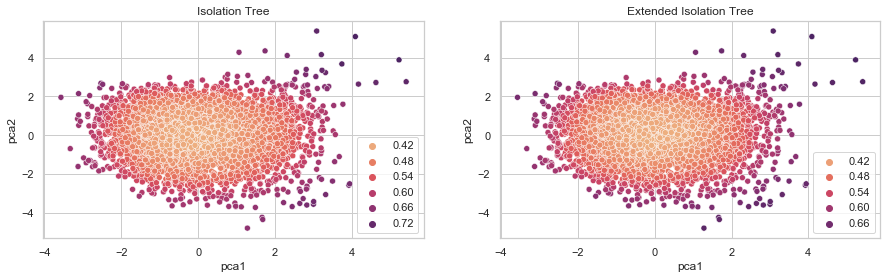

In [602]:
#
f = plt.figure(figsize=(15,4))

ax1 = f.add_subplot(121)
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=S0,palette='flare')
plt.title('Isolation Tree')

ax2 = f.add_subplot(122)
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=S1,palette='flare')
plt.title('Extended Isolation Tree')


### Anomaly Score Distribution 

Anomaly are scores with a value betwee 0 and 1.<br>
The higher the score the more likely the observation is an outlier.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


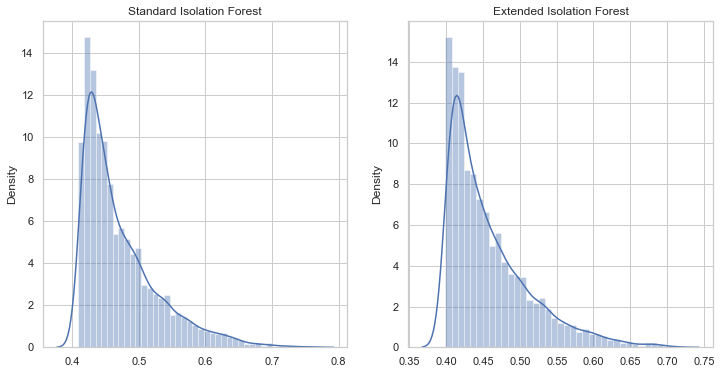

In [603]:
f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(S0, kde=True, color="b")
plt.title('Standard Isolation Forest')

plt.subplot(1,2,2)
sns.distplot(S1, kde=True, color="b")
plt.title('Extended Isolation Forest')
plt.show()

### Anomaly Score Map

In [604]:
xx, yy = np.meshgrid(np.linspace(-5., 6., 20), np.linspace(-5., 6, 20))

S0_ = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0_ = S0_.reshape(xx.shape)

S1_ = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1_ = S1_.reshape(xx.shape)

In [605]:
S0_.shape

(20, 20)

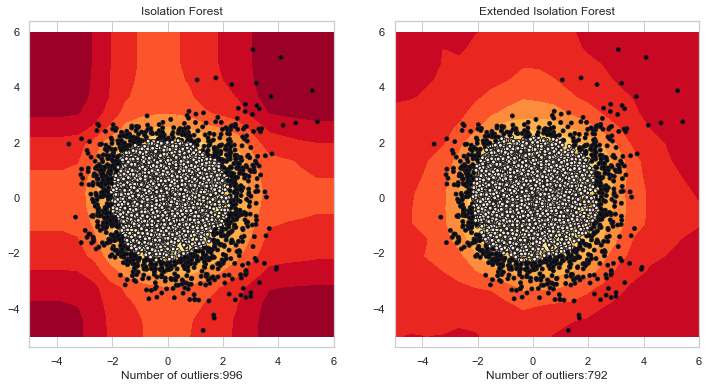

In [606]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0_),np.max(S0_),10)
CS = ax1.contourf(xx, yy, S0_, levels, cmap=plt.cm.YlOrRd)
plt.scatter(df_pca['pca1'],df_pca['pca2'],s=15,c=df['outlier_IF-PCA'].apply(lambda x: 0 if x=='inlier' else -1),edgecolors='k')
plt.axis("equal")
plt.title('Isolation Forest')
plt.xlabel(f"Number of outliers:{df['outlier_IF-PCA'].value_counts()[1]}")



ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1_),np.max(S0_),10)
CS = ax2.contourf(xx, yy, S1_, levels, cmap=plt.cm.YlOrRd)
plt.scatter(df_pca['pca1'],df_pca['pca2'],s=15,c=df['outlier_EIF-PCA'].apply(lambda x: 0 if x=='inlier' else -1),edgecolors='k')
plt.axis("equal")
plt.title('Extended Isolation Forest')
plt.xlabel(f"Number of outliers:{df['outlier_EIF-PCA'].value_counts()[1]}")

plt.show()

** Legend **<br>
white points** = inliers<br>
**balck point** = outliers<br>
**score threshold** = 0.6

## Auto Encoder (optional) 

In [607]:
help(AutoEncoder)

Help on class AutoEncoder in module pyod.models.auto_encoder:

class AutoEncoder(pyod.models.base.BaseDetector)
 |  AutoEncoder(hidden_neurons=None, hidden_activation='relu', output_activation='sigmoid', loss=<function mean_squared_error at 0x7fad9dbbed40>, optimizer='adam', epochs=100, batch_size=32, dropout_rate=0.2, l2_regularizer=0.1, validation_size=0.1, preprocessing=True, verbose=1, random_state=None, contamination=0.1)
 |  
 |  Auto Encoder (AE) is a type of neural networks for learning useful data
 |  representations unsupervisedly. Similar to PCA, AE could be used to
 |  detect outlying objects in the data by calculating the reconstruction
 |  errors. See :cite:`aggarwal2015outlier` Chapter 3 for details.
 |  
 |  Parameters
 |  ----------
 |  hidden_neurons : list, optional (default=[64, 32, 32, 64])
 |      The number of neurons per hidden layers.
 |  
 |  hidden_activation : str, optional (default='relu')
 |      Activation function to use for hidden layers.
 |      All hi

In [608]:
from pyod.models.auto_encoder import AutoEncoder

In [609]:
scaled_df.shape

(4133, 10)

In [610]:
scaled_df

array([[ 1.02985274,  0.31691984,  0.07801309, ...,  0.02693708,
        -0.74576189,  0.19265136],
       [-0.75595289,  0.28577395, -0.51298494, ..., -0.20549598,
         0.36763498,  0.19265136],
       [ 0.03025499,  0.15425321, -0.55639444, ...,  0.23488772,
         0.49540183,  0.19265136],
       ...,
       [-1.32137482,  1.53890309,  1.2777149 , ..., -0.07930346,
        -0.07042281,  1.39291979],
       [-1.29503999,  1.73814459,  1.32968483, ..., -0.97729256,
        -0.13886933,  1.39291979],
       [-1.3662832 , -0.77481062,  0.93070439, ..., -1.31689625,
        -0.10692762,  1.39291979]])

In [611]:
clf = AutoEncoder(hidden_neurons=[10, 5, 10], #under-complete autoencoder
                  hidden_activation='tanh',
                  output_activation='tanh', # tanh because the inputs are 
                  epochs=100,
                  validation_size= 0.3)

In [612]:
clf.fit(scaled_df)

outliers = clf.predict(scaled_df)
np.unique(outliers, return_counts=True)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_57 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_58 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_59 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 5)               

Epoch 65/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8495 - val_loss: 0.8138
Epoch 66/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8526 - val_loss: 0.8161
Epoch 67/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8533 - val_loss: 0.8182
Epoch 68/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8538 - val_loss: 0.8169
Epoch 69/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8515 - val_loss: 0.8129
Epoch 70/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8531 - val_loss: 0.8137
Epoch 71/100
91/91 [==============================] - 0s 4ms/step - loss: 0.8512 - val_loss: 0.8166
Epoch 72/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8526 - val_loss: 0.8145
Epoch 73/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8556 - val_loss: 0.8090
Epoch 74/100
91/91 [==============================] - 0s 4ms/step - loss: 0.8531 - val_loss: 0.8110


(array([0, 1]), array([3719,  414]))

In [613]:
df['outlier_AutoEncoder'] = outliers
df['outlier_AutoEncoder'] = df['outlier_AutoEncoder'].apply(lambda x: 'inlier' if x==0 else 'outlier')

## Removing Outliers

Algorithms employed:
1. DBSCAN
2. KNN
3. LOF
4. ABOD
5. Isolation Forest
6. Extended Isolation Forest

Based on the scores provided by each outlier detection method, we will take a majority voting in order to determine if a point x is an outlier or an inlier.

In [614]:
df[['outlier_DBSCAN', 'outlier_LOF', 'outlier_ABOD', 'outlier_IF-PCA',
       'outlier_EIF-PCA','outlier_IF',
       'outlier_EIF' ,'outlier_KNN']][df['outlier_DBSCAN']=='outlier']

,outlier_DBSCAN,outlier_LOF,outlier_ABOD,outlier_IF-PCA,outlier_EIF-PCA,outlier_IF,outlier_EIF,outlier_KNN
track_id,,,,,,,,
154,outlier,outlier,inlier,outlier,outlier,inlier,inlier,inlier
155,outlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier
238,outlier,outlier,inlier,outlier,outlier,inlier,inlier,inlier
313,outlier,outlier,inlier,outlier,outlier,inlier,inlier,inlier
314,outlier,inlier,inlier,outlier,outlier,inlier,inlier,inlier
...,...,...,...,...,...,...,...,...
105958,outlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier
111209,outlier,inlier,inlier,outlier,outlier,inlier,inlier,inlier
111210,outlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier


In [615]:

mostCommonVote=[]
for row in df[['outlier_DBSCAN', 'outlier_LOF', 'outlier_ABOD','outlier_IF',
       'outlier_EIF' ,'outlier_IF-PCA',
       'outlier_EIF-PCA','outlier_KNN','outlier_AutoEncoder']].values:
    votes, values = np.unique(row, return_counts=True)
    if np.all(values<=1):
            mostCommonVote.append( row[0] )
    else:
        mostCommonVote.append( votes[np.argmax(values)] )

df['Winner'] = mostCommonVote

In [616]:
df[['Winner']].value_counts()

Winner 
inlier     3946
outlier     187
dtype: int64

In [617]:
df[df['Winner']=='outlier']

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,outlier_DBSCAN,outlier_LOF,outlier_KNN,outlier_ABOD,outlier_IF-PCA,outlier_EIF-PCA,outlier_IF,outlier_EIF,outlier_AutoEncoder,Winner
track_id,,,,,,,,,,,,,,,,,,,,
155,0.981657,0.142249,0.912122,9.672940e-01,0.363510,0.087527,0.034325,91.912,756,192,outlier,outlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier,outlier
175,0.993928,0.310090,0.952493,2.743115e-01,0.354231,0.825744,0.033402,69.413,111,192,inlier,inlier,outlier,outlier,inlier,inlier,outlier,outlier,outlier,outlier
325,0.927950,0.517065,0.128993,9.014820e-01,0.240380,0.396333,0.484224,114.819,199,256,inlier,inlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier,outlier
333,0.955110,0.516984,0.113656,1.284000e-06,0.208705,0.713185,0.389561,92.490,96,256,outlier,inlier,outlier,inlier,outlier,outlier,inlier,outlier,outlier,outlier
347,0.734669,0.724325,0.348330,9.583185e-01,0.121680,0.413083,0.929918,134.024,150,256,outlier,inlier,inlier,outlier,outlier,outlier,inlier,inlier,outlier,outlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104693,0.162173,0.598020,0.736229,8.120000e-08,0.054555,0.227596,0.879723,200.098,192,192,outlier,outlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier,outlier
105958,0.574192,0.734285,0.695884,9.000000e-10,0.109506,0.245516,0.823207,159.967,152,192,outlier,outlier,outlier,outlier,outlier,outlier,inlier,inlier,inlier,outlier
111210,0.832811,0.822094,0.432160,2.487458e-03,0.390645,0.036261,0.952613,125.112,201,256,outlier,outlier,outlier,outlier,outlier,outlier,inlier,inlier,inlier,outlier


In [618]:
df[df['Winner']=='outlier'].index

Int64Index([   155,    175,    325,    333,    347,    351,    606,    607,
               778,    825,
            ...
             72063,  75198,  75202,  75208,  91049, 104693, 105958, 111210,
            111213, 122467],
           dtype='int64', name='track_id', length=187)

In [619]:
for col in df.columns:
    outlier_detector(var=col)
    print('\n')

acousticness:
Q1: 0.0943255199
Q3: 0.8984479226
IQR: 0.8041224026999999
lower range: -1.1118580841499999
upper range: 2.1046315266499995
acousticness has 0 potential outliers


danceability:
Q1: 0.2718615333
Q3: 0.5014793736
IQR: 0.22961784029999993
lower range: -0.07256522714999986
upper range: 0.8459061340499998
danceability has 11 potential outliers


energy:
Q1: 0.4328016497
Q3: 0.850100651
IQR: 0.41729900129999997
lower range: -0.19314685224999995
upper range: 1.47604915295
energy has 0 potential outliers


instrumentalness:
Q1: 0.4706153581
Q3: 0.9221123476
IQR: 0.45149698950000006
lower range: -0.2066301261500001
upper range: 1.5993578318500001
instrumentalness has 0 potential outliers


liveness:
Q1: 0.1042909085
Q3: 0.2091967113
IQR: 0.1049058028
lower range: -0.0530677957
upper range: 0.36655541550000004
liveness has 413 potential outliers


speechiness:
Q1: 0.0356185229
Q3: 0.0652800763
IQR: 0.029661553400000006
lower range: -0.008873807200000007
upper range: 0.1097724064000

TypeError: can't multiply sequence by non-int of type 'float'

In [620]:
df = df.drop(index=df[df['Winner']=='outlier'].index, axis=0)

In [621]:
df.iloc[:,:10]

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate
track_id,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,0.788251,128.537,82,256
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,0.650452,120.790,326,256
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,0.682397,135.468,354,256
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,0.917613,120.218,232,256
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,0.034018,90.241,405,256
...,...,...,...,...,...,...,...,...,...,...
123823,0.303772,0.227905,0.207037,0.664426,0.129962,0.036349,0.031072,99.323,425,255
123824,0.497877,0.328307,0.604455,0.909813,0.127005,0.040391,0.037689,101.553,526,262
124184,0.022261,0.638672,0.955109,0.802745,0.352897,0.072761,0.143388,124.996,230,320


In [622]:
scaled_clean= scaler.fit_transform(df.iloc[:,:10])

In [623]:
pca = PCA(2,random_state=42)
pca.fit(scaled_clean)
df_clean = pca.transform(scaled_clean)
df_clean = pd.DataFrame(df_clean, columns= ['pca1', 'pca2'])

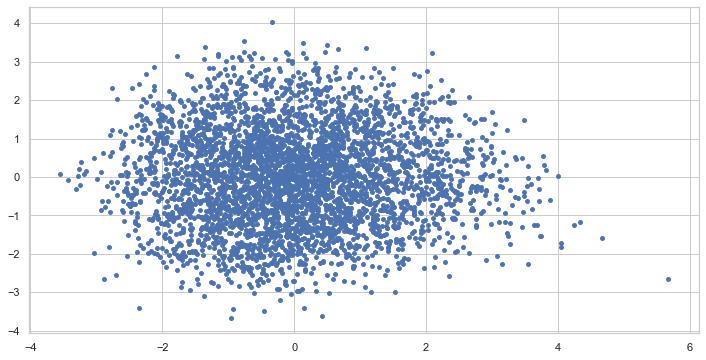

In [624]:
plt.figure(figsize=(12,6))
plt.scatter(df_clean['pca1'],df_clean['pca2'],s=15)

In [625]:
df_clean[df_clean['pca1']>4]

,pca1,pca2
19,4.336462,-1.170441
764,5.670513,-2.645232
1085,4.045791,-1.717095
1578,4.661558,-1.592901
1917,4.004674,0.016661
2698,4.038876,-1.811299
3189,4.241778,-1.252596


In [626]:
df.iloc[764]

acousticness            0.53566
danceability           0.439571
energy                 0.471031
instrumentalness       0.017775
liveness               0.125818
speechiness            0.059327
valence                0.377288
tempo                   139.157
duration                   2251
bit_rate                    256
outlier_DBSCAN           inlier
outlier_LOF              inlier
outlier_KNN              inlier
outlier_ABOD            outlier
outlier_IF-PCA          outlier
outlier_EIF-PCA         outlier
outlier_IF               inlier
outlier_EIF              inlier
outlier_AutoEncoder     outlier
Winner                   inlier
Name: 4162, dtype: object

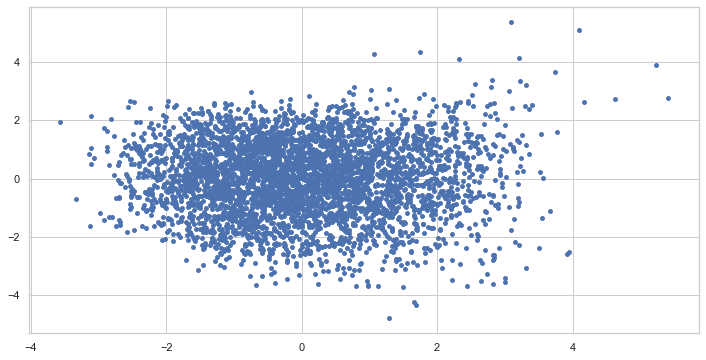

In [627]:
plt.figure(figsize=(12,6))
plt.scatter(df_pca['pca1'],df_pca['pca2'],s=15)

In [628]:
df[df['outlier_AutoEncoder']=='outlier']

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,outlier_DBSCAN,outlier_LOF,outlier_KNN,outlier_ABOD,outlier_IF-PCA,outlier_EIF-PCA,outlier_IF,outlier_EIF,outlier_AutoEncoder,Winner
track_id,,,,,,,,,,,,,,,,,,,,
174,0.367393,0.339698,0.846639,0.909186,0.198944,0.462607,0.048243,70.887,199,192,inlier,inlier,outlier,outlier,inlier,inlier,inlier,inlier,outlier,inlier
179,0.958873,0.274609,0.989482,0.919362,0.546516,0.185316,0.033208,84.173,90,320,inlier,inlier,outlier,outlier,inlier,inlier,inlier,inlier,outlier,inlier
311,0.566658,0.669095,0.057540,0.121328,0.106270,0.051355,0.694344,188.940,205,256,inlier,inlier,inlier,outlier,outlier,outlier,inlier,inlier,outlier,inlier
312,0.990320,0.362014,0.486088,0.848269,0.093921,0.567185,0.376977,91.320,199,256,inlier,inlier,outlier,outlier,inlier,inlier,inlier,inlier,outlier,inlier
326,0.933332,0.614193,0.711231,0.844747,0.154400,0.579897,0.380920,197.924,105,256,inlier,inlier,outlier,outlier,inlier,inlier,inlier,inlier,outlier,inlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71373,0.361267,0.593223,0.187853,0.679082,0.225577,0.028590,0.039671,88.573,312,121,inlier,inlier,inlier,outlier,inlier,inlier,inlier,inlier,outlier,inlier
86127,0.849874,0.363974,0.189257,0.000023,0.093570,0.051733,0.462805,208.653,341,256,inlier,inlier,outlier,outlier,inlier,inlier,inlier,inlier,outlier,inlier
90691,0.000015,0.205590,0.837619,0.000042,0.081056,0.040788,0.492847,93.306,203,128,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,outlier,inlier
